In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
data1 = pd.read_csv('/content/gdrive/My Drive/selected_dataset/drugsComTrain_raw.csv')

In [ ]:
data2 = pd.read_csv("/content/gdrive/My Drive/selected_dataset/drugsComTest_raw.csv")

In [ ]:
data = pd.concat([data1,data2])[['review','condition']]

In [ ]:
data.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [ ]:
# remove NULL Values from data
data = data[pd.notnull(data['review'])]

In [ ]:
data['len'] = data['review'].apply(lambda s : len(s))

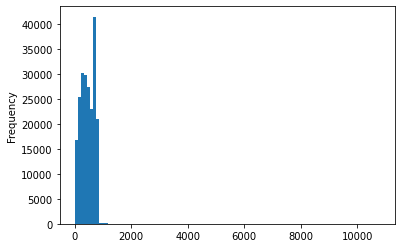

In [ ]:
data['len'].plot.hist(bins=100)

In [ ]:
data.len.quantile(0.9)

758.0

In [ ]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [ ]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [ ]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  

In [ ]:
data = data[data['condition']!='OTHER']

In [ ]:
import plotly.express as px

In [ ]:
px.bar(count_df[count_df['review']>3000],x='condition',y='review')

In [ ]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [ ]:
# lower the text
data["review"] = data["review"].apply(lambda x: x.lower())

# Clean the text
data["review"] = data["review"].apply(lambda x: clean_text(x))

# Clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["review"] = data["review"].apply(lambda x: replace_contractions(x))


In [ ]:
data['condition'].unique()

array(['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'],
                                                    stratify=data['condition'], 
                                                    test_size=0.25)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Diabetes, Type 2', 'Emergency Contraception',
       'High Blood Pressure', 'Insomnia', 'Obesity', 'Pain',
       'Vaginal Yeast Infection', 'Weight Loss'], dtype=object)

In [ ]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/content/gdrive/My Drive/selected_dataset/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [ ]:
np.shape(embedding_matrix)

(30976, 300)

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [ ]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=492.4495 	 val_loss=248.7240  	 val_acc=0.8352  	 time=85.40s
Epoch 2/6 	 loss=234.3229 	 val_loss=207.0224  	 val_acc=0.8583  	 time=88.54s
Epoch 3/6 	 loss=202.7353 	 val_loss=192.3367  	 val_acc=0.8659  	 time=88.22s
Epoch 4/6 	 loss=184.3230 	 val_loss=180.8948  	 val_acc=0.8731  	 time=88.23s
Epoch 5/6 	 loss=168.2191 	 val_loss=172.9024  	 val_acc=0.8779  	 time=88.38s
Epoch 6/6 	 loss=156.3787 	 val_loss=168.6905  	 val_acc=0.8825  	 time=88.25s


In [ ]:
torch.save(model,'textcnn_model')

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

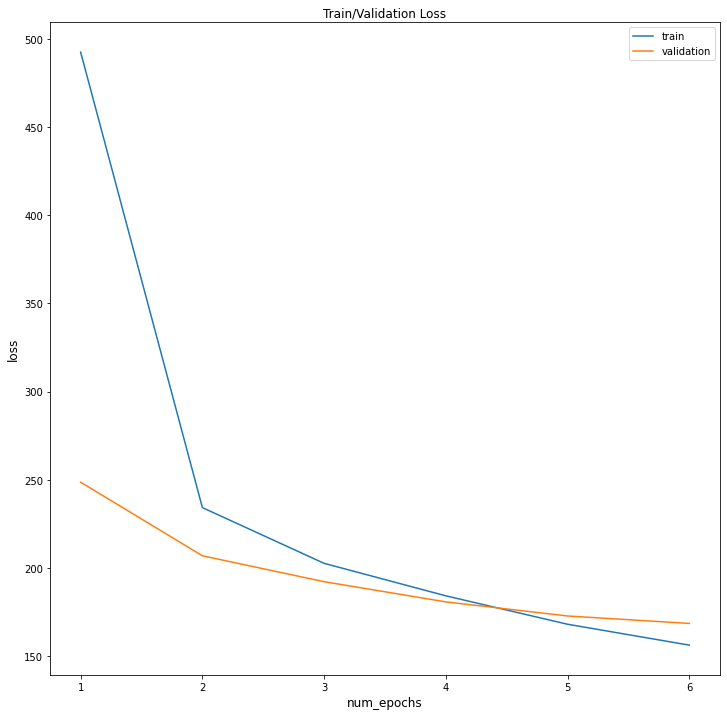

In [ ]:
plot_graph(n_epochs)

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


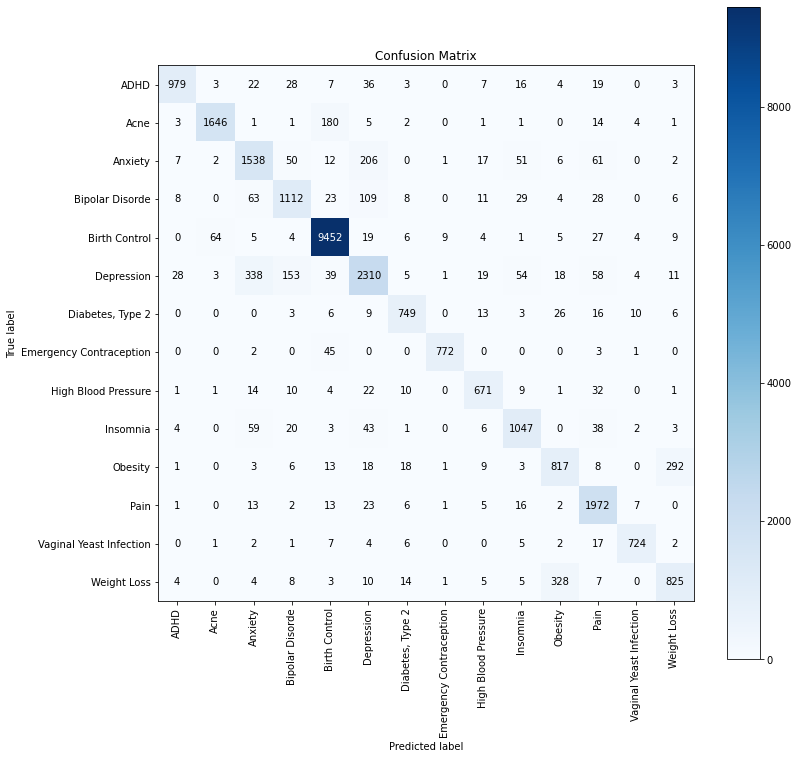

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)